In [1]:
global_parameters = {
    # 날짜별 에러 정보를 유저 아이디로 취합할 때 사용할 quantile 값
    'quantile': [0.25, 0.75],
    
    # LGBM 앙상블 학습시 사용할 fold 개수
    'nfold': 10,
    
    # STMOE 알고리즘에 대해 멀티 프로세싱을 사용할지 여부, (workers.py 파일이 존재해야함)
    'multiprocessing_for_smote': True,
    
    # 데이터 세트에 x개 이상 정보가 에러타입_코드 칼럼만 사용
    'min_errcode_sample': 75,
    
    # pearson 상관계수를 이용하여 x 값 이상인 칼럼을 제거함 (1을 초과할 경우 작동하지 않음)
    'pearson_cutoff': 1,
    
    # lgbm에서 seed를 변경하여 앙상블 모델의 다양성 추가 (기본값1)
    'lgbm_seed_ensemble': 1,
}

In [2]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
import collections

warnings.filterwarnings(action='ignore')

PATH = '../data/'
def make_days(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    return (dt.date(year, month, day) - dt.date(2020, 10, 31)).days

def string2num(x):
    # (,)( )과 같은 불필요한 데이터 정제
    x = re.sub(r"[^\-0-9\.]+", '', str(x))
    if x =='':
        return -1
    else:
        return int(float(x))

In [3]:
train_err = pd.read_csv(PATH+'train_err_data.csv')
train_err['days'] = train_err['time'].apply(make_days)
test_err = pd.read_csv(PATH+'test_err_data.csv')
test_err['days'] = test_err['time'].apply(make_days)

In [4]:
# 문자열(ex "1,000")로 되어있는 퀄리티 데이터 float 타입으로 변환
train_quality = pd.read_csv(PATH+'train_quality_data.csv')
for i in range(0,13,1):
    train_quality['quality_' + str(i)] = train_quality['quality_' + str(i)].apply(lambda x: string2num(x)).astype(float)
train_quality['days'] = train_quality['time'].apply(make_days)

test_quality = pd.read_csv(PATH+'test_quality_data.csv')
for i in range(0,13,1):
    test_quality['quality_' + str(i)] = test_quality['quality_' + str(i)].apply(lambda x: string2num(x)).astype(float)
test_quality['days'] = test_quality['time'].apply(make_days)

In [5]:
# [user_id, group]
quality_user_id = {}
for i in range(10000,45000):
    quality_user_id[i] = []
    for j in range(0,13):
        quality_user_id[i].append([])
        
for i, group in train_quality[train_quality.columns.difference(['time'])].groupby(['user_id']):
    for j in range(0,13):
        quality_user_id[i][j] = group.loc[group['quality_'+str(j)] != -1]['quality_'+str(j)].values
        
for i, group in test_quality[test_quality.columns.difference(['time'])].groupby(['user_id']):
    for j in range(0,13):
        quality_user_id[i][j] = group.loc[group['quality_'+str(j)] != -1]['quality_'+str(j)].values
        
quality_columns_preset =  ['quality_count'] + ['quality_sum'] + ['quality_mean']  + ['quality_var'] + ['quality_max'] + ['quality_std/mean']
quality_user_id_statistics = {}
for i in quality_user_id:
    quality_user_id_statistics[i] = []
    for j in range(0,13):
        a = np.array(quality_user_id[i][j])
        if (len(a) == 0):
            quality_user_id_statistics[i] += [0] + [-999] * (len(quality_columns_preset) - 1)
        else: 
            quality_user_id_statistics[i] += [len(a), a.sum(axis=0), a.mean(axis=0), a.var(axis=0), a.max(axis=0), a.std(axis=0) / a.mean(axis=0)]
quality_columns = []
quality_columns_index = {}
for i in range(0,13):
    for j in quality_columns_preset:
        # 어차피 이미 만들어진 퀄리티 데이터에 접근하지 않으니 index가 필요없음
        # quality_columns_index[column_name] = len(quality_columns)
        quality_columns.append(j + '_' + str(i))

In [6]:
# 33일 넘기는 테스트 데이터 제거
test_err = test_err.loc[test_err['days'] < 33]

In [7]:
# white_list = {(25, 'scanning timeout'), (8, 'PHONE_ERR'), (36, '8.0'), (5, 'Q-64002'), (19, '1'), (30, '1'), (25, 'connectionterminated by local host'), (21, '1'), (1, 'P-41007'), (25, '2'), (5, 'Q-64001'), (4, '0'), (37, '0'), (25, '1'), (25, 'UNKNOWN'), (18, '1'), (17, '21'), (1, '0'), (20, '1'), (1, 'P-44010'), (5, 'U-82026'), (3, '0'), (23, 'terminate by peer user')}
white_list_code = {'Q-64001', 'S-65002', '21', 'Q-64002', 'PHONE_ERR', '3', 'scanning timeout', 'NFANDROID2', '2', 'U-82026', 'P-41007', 'V-21008', 'P-44010', '8.0', 'terminate by peer user'}

In [8]:
test_type_code = set()
for i, group in test_err.groupby(['errtype', 'errcode']):
    if len(group['user_id'].unique()) >= global_parameters['min_errcode_sample']:
        test_type_code.add((i[0], i[1]))

same_type_code = []
for i, group in train_err.groupby(['errtype', 'errcode']):
    if len(group['user_id'].unique()) >= global_parameters['min_errcode_sample'] and (i[0], i[1]) in test_type_code:
        same_type_code.append((i[0],i[1]))

In [9]:
# error_type, error_code 매핑
def key_typecode(t,c = None):
    if c == None:
        return "errcode_" + str(t).strip()
    
    return str(t).strip() + '_' + str(c).strip()

columns = []
column_index = {}
count = 0
for i in same_type_code:
    key = key_typecode(i[0], i[1])
    if key not in columns:
        columns.append(key)
        column_index[key] = count
        count += 1
'''        
for i in white_list_code:
    key = key_typecode(i)
    if key not in columns:
        columns.append(key)
        column_index[key] = count
        count += 1
        '''
            
print("검색된 칼럼 수", len(columns))

검색된 칼럼 수 99


In [10]:
def make_err_table(table, start_user_id, size):    
    id_error = table[['user_id','errtype','errcode', 'days']].values
    error = np.zeros((size, 33, 42 + len(columns)))    
    
    days = np.zeros((size, 33))
    
    for person_idx, err, code, day in tqdm(id_error):
        user_index = person_idx - start_user_id
        # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
        error[user_index, day, err - 1] += 1
        days[user_index, day] = 1
        key = key_typecode(err - 1, code)
        if key in column_index:
            error[user_index, day, 42 + column_index[key]] += 1
           
        # 에러 코드별 합계를 추가하고싶으면 아래 주석 해제
        '''
        key = key_typecode(code)
        if key in column_index:
            error[person_idx - start_user_id, day_key, 42 + column_index[key]] += 1
        '''
       
    
    error_sum = np.sum(error, axis=1)
    error_std = np.std(error, axis=1)
    error_max = np.max(error, axis=1)
    
    error_cv = np.std(error, axis=1) / np.mean(error, axis=1)
    
    error_cv[np.isnan(error_cv)] = 0
    
    quantile_arr = np.quantile(error, global_parameters['quantile'], axis=1)
    #sum_days = np.sum(days, axis=1).reshape(-1,1)
    
    # weekday_error_sum = np.sum(weekday_error, axis=1)
    # weekday_error_std = np.std(weekday_error, axis=1)
    # weekday_error_max = np.max(weekday_error, axis=1)
    
     
    total = np.concatenate([error_sum, error_std, error_max, error_cv] + [i for i in quantile_arr]
                           , axis=1)
    quantile_columns = []
    temp_columns = [str(i) for i in range(0,42)] + columns
    for q in global_parameters['quantile']:
        quantile_columns.extend([str(int(q * 100)) + '_' + str(i) for i in temp_columns])
        
    
    result = pd.DataFrame(data=total, columns=
                          ['sum_' + str(i) for i in temp_columns] + 
                          ['std_' + str(i) for i in temp_columns] + 
                          ['max_' + str(i) for i in temp_columns] +
                          ['cv_' + str(i) for i in temp_columns] +
                          quantile_columns)
    
    # 에러와 관련이 없는 부가 정보 입력
    
    # quality 데이터 연결
    result['user_id'] = range(start_user_id, start_user_id + size)
    for i in tqdm(range(0,len(quality_columns))):
        result.loc[:, quality_columns[i]] = result['user_id'].apply(lambda x: quality_user_id_statistics[x][i])
    
    user_model={}
    for user_id, group in table.groupby(['user_id']):
        user_model[user_id] = group.iloc[0]['model_nm']
        
    result["model_nm"] = result["user_id"].apply(lambda x : user_model[x]).astype('category')
    
    del result['user_id'] # user_id는 학습에 사용되지 않아야하기 때문에 삭제
    return result

train_full = make_err_table(train_err, start_user_id=10000, size=15000)


100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 19.32it/s]


In [11]:
train_full

,sum_0,sum_1,sum_2,sum_3,sum_4,sum_5,sum_6,sum_7,sum_8,sum_9,sum_10,sum_11,sum_12,sum_13,sum_14,sum_15,sum_16,sum_17,sum_18,sum_19,sum_20,sum_21,sum_22,sum_23,sum_24,sum_25,sum_26,sum_27,sum_28,sum_29,sum_30,sum_31,sum_32,sum_33,sum_34,sum_35,sum_36,sum_37,sum_38,sum_39,sum_40,sum_41,sum_1_0,sum_1_P-41007,sum_1_P-44010,sum_2_0,sum_2_1,sum_3_1,sum_3_2,sum_4_0,sum_4_1,sum_5_700001,sum_5_B-A8002,sum_5_C-11017,sum_5_H-51042,sum_5_H-51046,sum_5_Q-64002,sum_5_S-61001,sum_5_S-64002,sum_5_S-65002,sum_5_V-21008,sum_6_1,sum_6_14,sum_7_1,sum_7_14,sum_10_1,sum_11_1,sum_12_1,sum_13_1,sum_14_1,sum_14_13,sum_14_14,sum_15_1,sum_16_1,sum_17_1,sum_17_13,sum_17_14,sum_17_21,sum_18_1,sum_19_1,sum_20_1,sum_21_1,sum_22_1,sum_23_UNKNOWN,sum_23_active,sum_23_connection fail for LMP response timout,sum_23_connection fail to establish,sum_23_connection timeout,sum_23_connectionterminated by local host,sum_23_standby,sum_23_terminate by peer user,sum_24_1,sum_25_1,sum_25_2,sum_25_UNKNOWN,sum_25_scanning timeout,sum_26_1,sum_27_1,sum_28_1,sum_30_4,sum_31_0,sum_31_1,sum_32_76,sum_32_77,sum_32_78,sum_32_79,sum_32_80,sum_32_81,sum_32_82,sum_32_83,sum_32_84,sum_32_85,sum_32_86,sum_32_87,sum_32_88,sum_32_89,sum_32_90,sum_32_91,sum_32_92,sum_32_93,sum_32_94,sum_32_95,sum_33_1,sum_33_2,sum_33_3,sum_34_1,sum_34_2,sum_34_3,sum_34_4,sum_34_5,sum_34_6,sum_35_1,sum_36_8.0,sum_37_0,sum_39_0,sum_39_1,sum_40_0,sum_40_1,sum_41_NFANDROID2,sum_42_2,sum_42_3,std_0,std_1,std_2,std_3,std_4,std_5,std_6,std_7,std_8,std_9,std_10,std_11,std_12,std_13,std_14,std_15,std_16,std_17,std_18,std_19,std_20,std_21,std_22,std_23,std_24,std_25,std_26,std_27,std_28,std_29,std_30,std_31,std_32,std_33,std_34,std_35,std_36,std_37,std_38,std_39,std_40,std_41,std_1_0,std_1_P-41007,std_1_P-44010,std_2_0,std_2_1,std_3_1,std_3_2,std_4_0,std_4_1,std_5_700001,std_5_B-A8002,std_5_C-11017,std_5_H-51042,std_5_H-51046,std_5_Q-64002,std_5_S-61001,std_5_S-64002,std_5_S-65002,std_5_V-21008,std_6_1,std_6_14,std_7_1,std_7_14,std_10_1,std_11_1,std_12_1,std_13_1,std_14_1,std_14_13,std_14_14,std_15_1,std_16_1,std_17_1,std_17_13,std_17_14,std_17_21,std_18_1,std_19_1,std_20_1,std_21_1,std_22_1,std_23_UNKNOWN,std_23_active,std_23_connection fail for LMP response timout,std_23_connection fail to establish,std_23_connection timeout,std_23_connectionterminated by local host,std_23_standby,std_23_terminate by peer user,std_24_1,std_25_1,std_25_2,std_25_UNKNOWN,std_25_scanning timeout,std_26_1,std_27_1,std_28_1,std_30_4,std_31_0,std_31_1,std_32_76,std_32_77,std_32_78,std_32_79,std_32_80,std_32_81,std_32_82,...,25_32_85,25_32_86,25_32_87,25_32_88,25_32_89,25_32_90,25_32_91,25_32_92,25_32_93,25_32_94,25_32_95,25_33_1,25_33_2,25_33_3,25_34_1,25_34_2,25_34_3,25_34_4,25_34_5,25_34_6,25_35_1,25_36_8.0,25_37_0,25_39_0,25_39_1,25_40_0,25_40_1,25_41_NFANDROID2,25_42_2,25_42_3,75_0,75_1,75_2,75_3,75_4,75_5,75_6,75_7,75_8,75_9,75_10,75_11,75_12,75_13,75_14,75_15,75_16,75_17,75_18,75_19,75_20,75_21,75_22,75_23,75_24,75_25,75_26,75_27,75_28,75_29,75_30,75_31,75_32,75_33,75_34,75_35,75_36,75_37,75_38,75_39,75_40,75_41,75_1_0,75_1_P-41007,75_1_P-44010,75_2_0,75_2_1,75_3_1,75_3_2,75_4_0,75_4_1,75_5_700001,75_5_B-A8002,75_5_C-11017,75_5_H-51042,75_5_H-51046,75_5_Q-64002,75_5_S-61001,75_5_S-64002,75_5_S-65002,75_5_V-21008,75_6_1,75_6_14,75_7_1,75_7_14,75_10_1,75_11_1,75_12_1,75_13_1,75_14_1,75_14_13,75_14_14,75_15_1,75_16_1,75_17_1,75_17_13,75_17_14,75_17_21,75_18_1,75_19_1,75_20_1,75_21_1,75_22_1,75_23_UNKNOWN,75_23_active,75_23_connection fail for LMP response timout,75_23_connection fail to establish,75_23_connection timeout,75_23_connectionterminated by local host,75_23_standby,75_23_terminate by peer user,75_24_1,75_25_1,75_25_2,75_25_UNKNOWN,75_25_scanning timeout,75_26_1,75_27_1,75_28_1,75_30_4,75_31_0,75_31_1,75_32_76,75_32_77,75_32_78,75_32_79,75_32_80,75_32_81,75_32_82,75_32_83,75_32_84,75_32_85,75_32_86,75_32_87,75_32_88,75_32_89,75_32_90,75_32_91,75_32_92,75_32_93,75_32_94,75_32_95,75_33_1,75_33_2,75_33_3,75_34_1,75_34_2,75_3

In [12]:
for i in range(13):
    if "quality_std/mean_"+str(i) in train_full.columns:
        train_full["quality_std/mean_"+str(i)] = train_full["quality_std/mean_"+str(i)].fillna(0)

In [13]:
# 사용되지 않는 타입_코드 칼럼을 제거
#train_test = pd.concat([train_full, test], axis=0)
select_columns = []
for c in tqdm(train_full.columns):
    if str(train_full[c].dtype) == 'category':
        select_columns.append(c)
        continue
    if train_full[c].apply(lambda x: 1 if x > 0 else 0).sum() >= global_parameters['min_errcode_sample']: # 트레이닝, 테스트 세트에 50개 이상의 행이 있어야함
        select_columns.append(c)
    else:
        if 'custom_' in c:
            select_columns.append(c)
        '''
        # 코드 합계는 모두 통과 (화이트리스트)
        if 'sum_' in c or 'max_' in c or 'std_' in c:
            if 'errcode_' in c:
                select_columns.append(c)
                
        '''
        '''
        if 'sum_' in c or 'max_' in c or 'std_' in c:
            original_columns = c[4:].split('_')
            if len(original_columns) == 2 and original_columns[0] != 'errcode' and (int(original_columns[0]), original_columns[1]) in white_list:
                if 'sum_' in c:
                    print(c)
                select_columns.append(c)
        '''

print(len(train_full.columns), '개의 칼럼을', len(select_columns), '개로 압축')
train_full = train_full[select_columns]
columns = select_columns

100%|███████████████████████████████████████████████████████████████████████████████| 925/925 [00:03<00:00, 293.44it/s]

925 개의 칼럼을 405 개로 압축


In [14]:
if global_parameters['pearson_cutoff'] <= 1:
    org_train_full = train_full
    pearson_table = train_full.corr(method='pearson')
    pearson = []
    for i in train_full.columns:
        for j in train_full.columns:
            if (i >= j):
                continue
            if str(train_full[i].dtype) == 'category' or str(train_full[j].dtype) == 'category':
                continue
            pearson.append((i,j,pearson_table.loc[i,j]))
    pearson = sorted(pearson, key=lambda x: abs(x[2]), reverse=True)

    remove_columns = set()
    fix_columns = set()
    for i in pearson:
        # 이미 제거되었으면 넘기기
        if (i[0] in remove_columns or i[1] in remove_columns):
            continue
        if (abs(i[2]) >= global_parameters['pearson_cutoff']):
            remove_columns.add(i[1])

    print(len(train_full.columns), '개의 칼럼을', len(train_full.columns) - len(remove_columns), '개로 압축')
    train_full = train_full[train_full.columns.difference(list(remove_columns))]
    #test = test[test.columns.difference(list(remove_columns))]


405 개의 칼럼을 327 개로 압축


In [15]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
problem[train_prob.user_id.unique()-10000] = 1 
train_full['problem'] = problem

In [70]:
train_full.to_csv('분석용.csv', index=False)

In [65]:
def view_sc(data2, col1, col2, xlim=-1, ylim=-1):
    data = data2.loc[data2[col1] != -999]
    cols = [col1, col2]
    print(data[col1].sum())
    data_p = data.loc[data['problem'] == 1]
    data_np = data.loc[data['problem'] == 0]
    plt.scatter(data_p[col1], data_p[col2], color="#ff000055")
    plt.scatter(data_np[col1], data_np[col2], color="#0000ff55")
    if xlim != -1:
        plt.xlim(-xlim*0.01, xlim)
    if ylim != -1:
        plt.ylim(-ylim*0.01, ylim)
    plt.show()

In [72]:
def make_correlation2(data, method):
    r = {}
    for i in data.columns:
        for j in data.columns:
            if i >= j:
                continue
            if ('quality_' not in i and 'quality_' not in j) or ('quality_' in i and 'quality_' in j):
                continue
            if str(train_full[i].dtype) == 'category' or str(train_full[j].dtype) == 'category':
                continue
            if 'quality_' in i:
                quality_col = i
                error_col = j
            else:
                quality_col = j
                error_col = i
            score = data.loc[data[quality_col] != -999, [i,j]].corr(method = method).iloc[0,1]
            if (str(score) != 'nan'):
                r[i,j] = score
    return r

22236.0


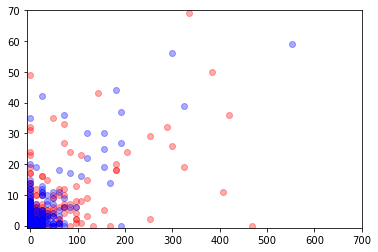

In [80]:
t = train_full.loc[train_full['model_nm'] == 'model_0', train_full.columns.difference(['model_nm'])]
view_sc(t, 'quality_sum_8', 'sum_16', xlim=700, ylim=70)

In [1]:
t = train_full.loc[train_full['model_nm'] == 'model_0', train_full.columns.difference(['model_nm'])]
view_sc(t, 'quality_sum_6', 'sum_34', xlim=2600, ylim=50)

NameError: name 'train_full' is not defined

In [81]:
t = train_full.loc[train_full['model_nm'] == 'model_0', train_full.columns.difference(['model_nm', 'problem'])]
r = make_correlation2(t, 'pearson')
for i in sorted(r, key=lambda x: -abs(r[x]))[0:50]:
    print(i, r[i])

print('spearman')
r = make_correlation2(t, 'spearman')
for i in sorted(r, key=lambda x: -abs(r[x]))[0:50]:
    print(i, r[i])

('quality_sum_8', 'sum_16') 0.9098000913140102
('quality_sum_1', 'sum_16') 0.9098000913139875
('quality_sum_8', 'std_16') 0.8278141916850145
('quality_sum_1', 'std_16') 0.8278141916849981
('max_16', 'quality_sum_8') 0.8171221531173336
('max_16', 'quality_sum_1') 0.8171221531173148
('max_16', 'quality_max_8') 0.7631444672474048
('quality_max_8', 'std_16') 0.7435948079284145
('quality_max_8', 'std_27') 0.6759550951092173
('quality_max_8', 'std_26') 0.6717011188575446
('max_27', 'quality_max_8') 0.6677745235106549
('max_16', 'quality_sum_11') 0.6646049799438045
('max_16', 'quality_sum_12') 0.6646049799438014
('quality_sum_11', 'std_16') 0.6640242885328744
('quality_sum_12', 'std_16') 0.6640242885328694
('max_26', 'quality_max_8') 0.662853136487538
('quality_sum_8', 'std_27') 0.6582942126615271
('quality_sum_1', 'std_27') 0.6582942126615242
('quality_sum_8', 'sum_27') 0.6580438085381868
('quality_sum_1', 'sum_27') 0.6580438085381731
('quality_sum_1', 'sum_26') 0.6578326761027669
('quality_

In [82]:
t = train_full.loc[train_full['model_nm'] == 'model_1', train_full.columns.difference(['model_nm', 'problem'])]
r = make_correlation2(t, 'pearson')
for i in sorted(r, key=lambda x: -abs(r[x]))[0:50]:
    print(i, r[i])

print('spearman')
r = make_correlation2(t, 'spearman')
for i in sorted(r, key=lambda x: -abs(r[x]))[0:50]:
    print(i, r[i])

('quality_sum_1', 'sum_16') 0.8992685275877723
('quality_sum_8', 'sum_16') 0.8992685275877641
('75_16', 'quality_sum_1') 0.7555212910636816
('75_16', 'quality_sum_8') 0.7555212910636729
('quality_sum_12', 'sum_37') 0.732191432338708
('quality_sum_11', 'sum_37') 0.7321914323386438
('quality_sum_1', 'std_16') 0.672577449465807
('quality_sum_8', 'std_16') 0.6725774494657975
('quality_max_8', 'std_16') 0.657839077011401
('quality_max_8', 'sum_16') 0.6247584808009332
('max_16', 'quality_max_8') 0.6063010906777764
('quality_var_8', 'std_16') 0.5619801713217137
('quality_max_1', 'std_16') 0.5543161368573332
('quality_var_8', 'sum_16') 0.5497498110905833
('max_16', 'quality_max_1') 0.5231085979929406
('quality_mean_8', 'std_16') 0.5206315350004944
('quality_max_1', 'sum_16') 0.5083265402646322
('max_16', 'quality_var_8') 0.5078209811382735
('max_16', 'quality_sum_8') 0.4976091600380537
('max_16', 'quality_sum_1') 0.49760916003804173
('quality_mean_8', 'sum_16') 0.4923542916243181
('quality_max